In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'pytorch-retinanet')

In [72]:
%matplotlib inline

In [73]:
#!pip install -U scikit-learn



In [74]:
import matplotlib.pyplot as plt
import cv2
from sklearn import cluster
import numpy as np

In [75]:
image = cv2.imread('images/resize.png') / 255

In [76]:
copy = image.copy()
copy[copy == 0] = 1

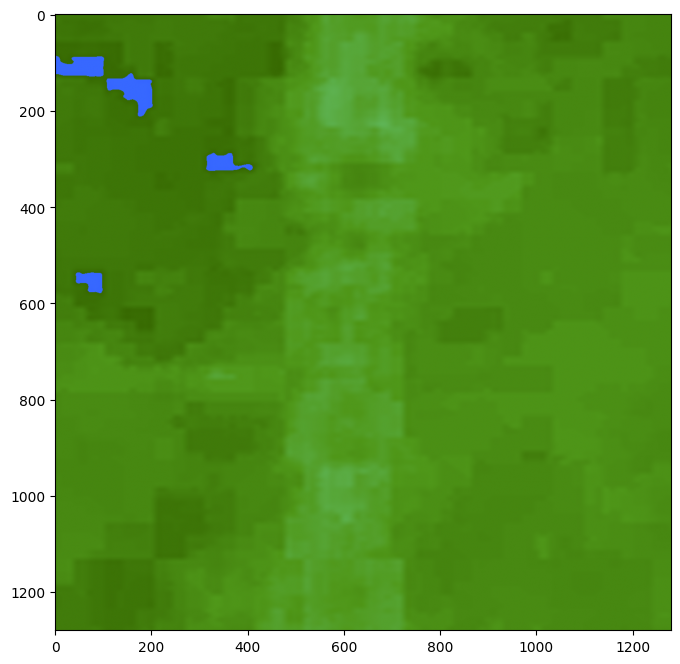

In [77]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(copy)
plt.show()

In [78]:
x, y, z = image.shape
image_2d = image.reshape(x*y, z)
image_2d.shape

(1638400, 3)

In [79]:
kmeans_cluster = cluster.KMeans(n_clusters=4)
kmeans_cluster.fit(image_2d)

/home/aniaraki@musco.com/anaconda3/envs/planb/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [80]:
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_
print(cluster_centers.shape, cluster_labels.shape)

segmented_image = cluster_centers[cluster_labels].reshape(x, y, z)

(4, 3) (1638400,)


In [81]:
# values to recognize the different clusters from kmeans
value = [4.69527965e-01, 8.39158637e-01, 7.10461527e-01]
min_ = 10000
label = 0
for i, c in enumerate(cluster_centers):
    cmp = np.min((np.abs(c-value)).sum()/3)
    if min_> cmp:
        min_ = cmp
        label = i
        
print('min', min_, label)

min 0.29203703464106034 1


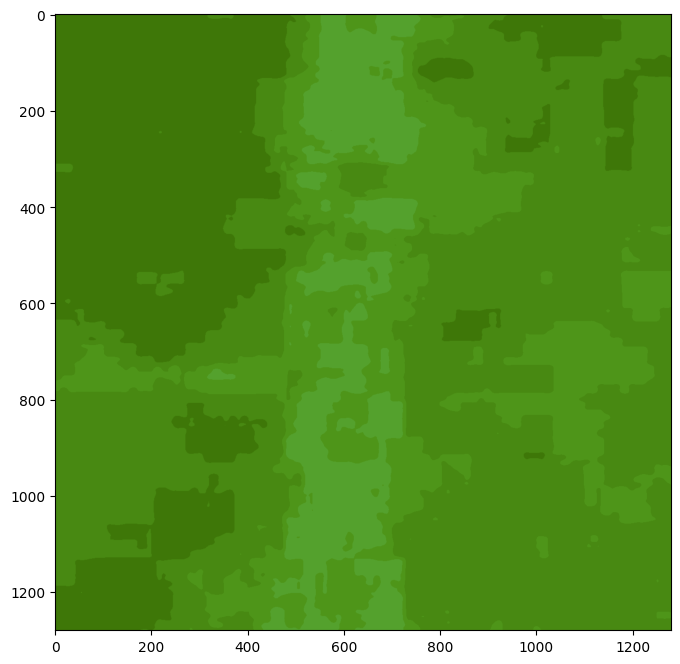

In [82]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image)
plt.show()

In [106]:
path = 'images'
# names = ['2021-7-13_field1_w0_h0', '2021-7-13_field1_w7680_h0', '2021-7-13_field1_w17920_h12800', '2021-7-13_field1_w17920_h14080', '2021-7-13_field1_w17920_h15360', '2021-7-13_field1_w17920_h16640']
names = ['2021-7-13_field1_w0_h0', '2021-7-13_field1_w7680_h0', '2021-7-13_field1_w17920_h12800', '2021-7-13_field1_w17920_h14080', '2021-7-13_field1_w17920_h15360', '2021-7-13_field1_w17920_h16640']

name = names[4] # pick one of the sample images

img = cv2.imread(f'{path}/NDVI/{name}.png') / 255
ndvi = img.copy()

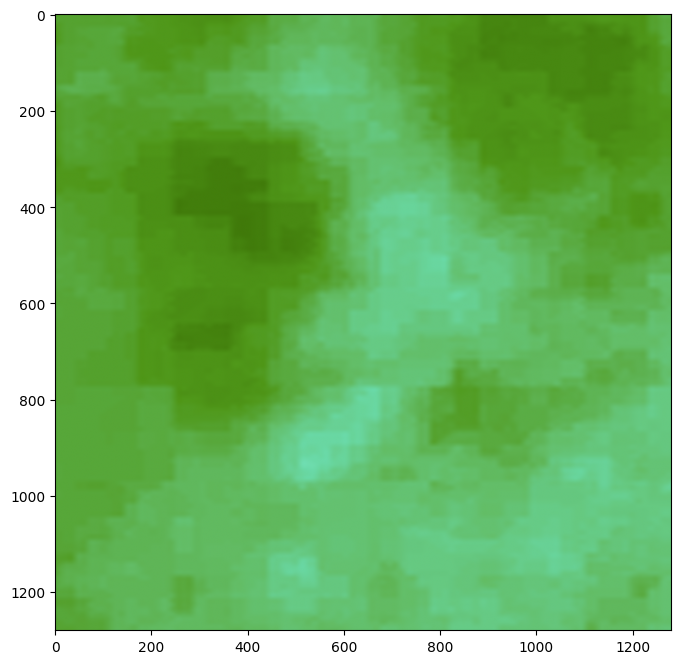

In [107]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.show()

In [108]:
x, y, z = img.shape
img_2d = img.reshape(x*y, z)
img_2d.shape

(1638400, 3)

In [109]:
out = kmeans_cluster.predict(img_2d)
out.shape

(1638400,)

In [110]:
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = out
print(cluster_centers.shape, cluster_labels.shape)

segmented_image = cluster_centers[cluster_labels].reshape(x, y, z)

(4, 3) (1638400,)


In [111]:
cluster_labels = kmeans_cluster.predict(img_2d)
row, col = np.where(cluster_labels.reshape(x, y) == label)
to_use = np.where(cluster_labels.reshape(x, y) == label)
print(type(to_use))
to_use = np.asarray(to_use).T
print(to_use.shape, row.reshape(row.shape[0], 1).shape, col.shape)

<class 'tuple'>
(1257010, 2) (1257010, 1) (1257010,)


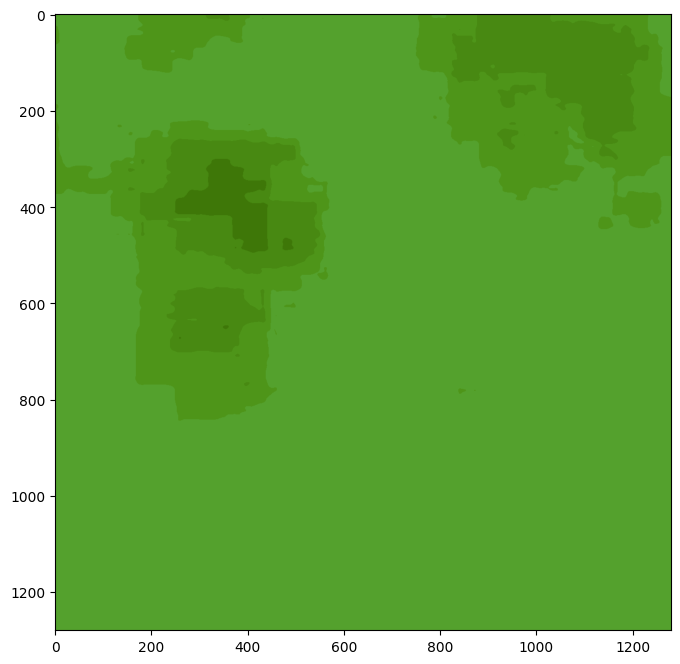

In [112]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image)
plt.show()

# Cluster based on positions

In [113]:
from sklearn.cluster import DBSCAN
if to_use.shape[0] != 0:
    clustering = DBSCAN(eps=10, min_samples=300).fit(to_use)
    clustering.labels_.shape, to_use.shape

# Draw BBOX

In [114]:
if to_use.shape[0] != 0:
    sel = 0
    segmented_image2 = img.copy() * 255
    for sel in np.unique(clustering.labels_):
        ind = clustering.labels_ == sel
        y1, y2 = np.min(to_use[ind, 0]), np.max(to_use[ind, 0])
        x1, x2 = np.min(to_use[ind, 1]), np.max(to_use[ind, 1])
        print(sel, x1, y1, x2, y2)
        if sel != -1:
            segmented_image2 = cv2.rectangle(segmented_image2, (x1, y1), (x2, y2), (255, 255, 255), 10)

    segmented_image2 = segmented_image2 / 255

-1 0 0 1279 1279
0 0 0 1279 1279
1 1232 0 1279 169
2 1060 277 1105 315


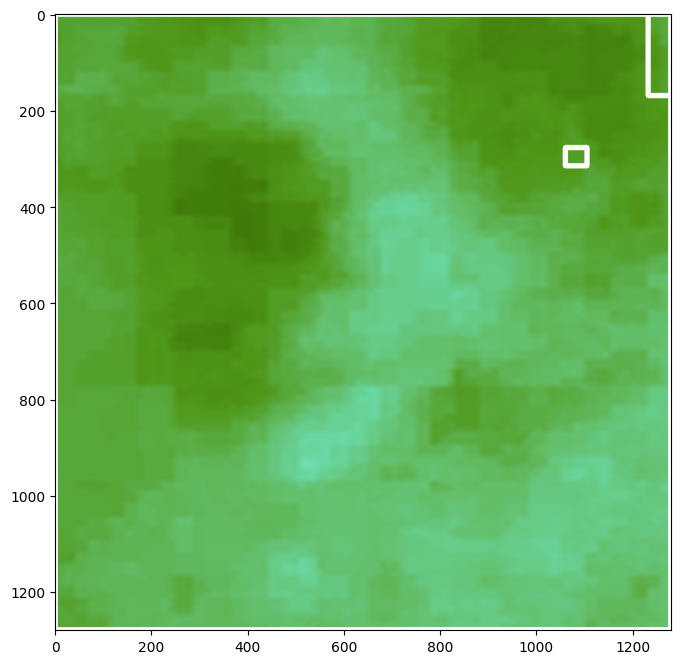

In [115]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image2)
plt.show()

# Model Output

In [116]:
class Parser:
    pass

# creates a parser
parser = Parser()
parser.supervised = True
parser.depth = 50
parser.num_classes = 1
parser.dim_out = 32
parser.model_path = 'weights/model_final.pt'

In [117]:
from retinanet import model
import torch
import torch.nn as nn

In [118]:
retinanet = model.resnet50(num_classes=1, pretrained=True)

In [119]:
use_gpu = True

if torch.cuda.is_available():
    print('loading')
    retinanet.load_state_dict(torch.load(parser.model_path).module.state_dict())
    retinanet = torch.nn.DataParallel(retinanet).cuda()
else:
    print('loading')
    retinanet.load_state_dict(torch.load(parser.model_path))
    retinanet = torch.nn.DataParallel(retinanet)

if use_gpu:
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()


retinanet.training = False
retinanet.module.freeze_bn()
retinanet.eval();

loading


In [120]:
img = cv2.imread(f'{path}/NDVI/{name}.png')
img = img.astype(np.float32)/255.0

In [121]:
from retinanet.dataloader import Normalizer, Resizer

In [122]:
#!pip install scikit-image

In [123]:
norm = Normalizer()
resizer = Resizer()

default = np.expand_dims(np.array([0, 0, 10, 10, 0]), 0)
default = default.astype('float64')

sample = {'img': img, 'annot': default}
sample = norm(sample)
sample = resizer(sample)
img = sample['img']

In [124]:
tensor_img = img.unsqueeze(0).permute(0, 3, 1, 2)
tensor_img = tensor_img.float().detach()
tensor_img.shape

torch.Size([1, 3, 1312, 1312])

In [125]:
import time
with torch.no_grad():
    scores, labels, boxes = retinanet(tensor_img)

In [126]:
scores = scores.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()
boxes  = boxes.cpu().detach().numpy()

In [127]:
segmented_image3 = segmented_image2.copy()
for box in boxes:
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])

    segmented_image3 = cv2.rectangle(segmented_image3, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


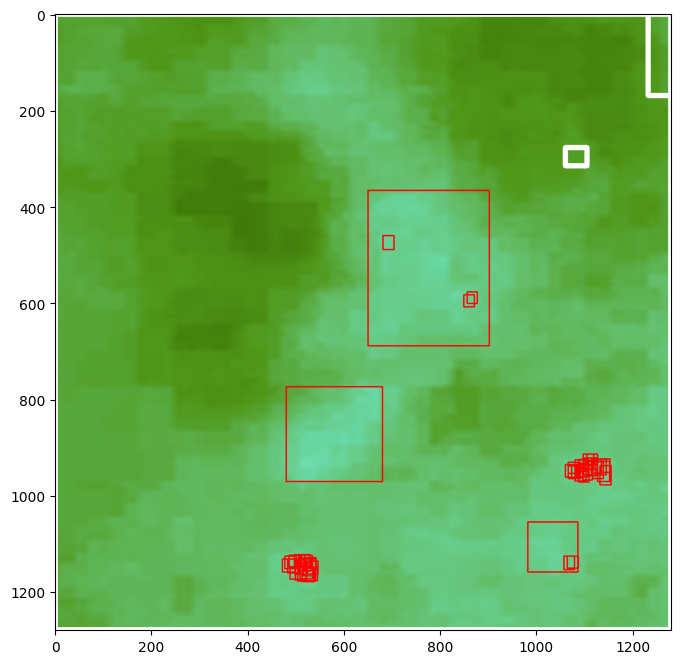

In [128]:
%matplotlib inline
plt.figure(figsize=(15, 8))
plt.imshow(segmented_image3)
plt.show()